In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
import trimesh
import numpy as np
import os

In [13]:
mesh = trimesh.load(r"A:\ВУЗМАГА\proect bredixin\broken_model\broken21.stl")

In [ ]:
voxel_data = mesh.voxelized(pitch=mesh.extents.max()/64)
voxels = voxel_data.matrix.astype(np.float32)

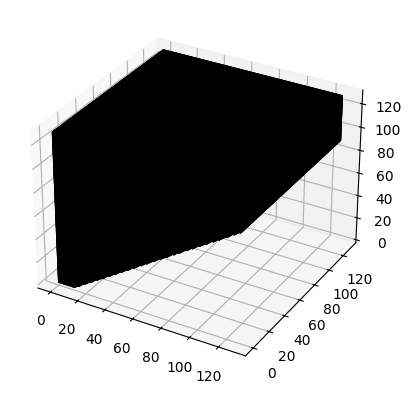

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.voxels(voxels, edgecolor='k')

plt.show()

In [27]:
def model_to_voxels(file_path, output_dir=None):

    mesh = trimesh.load(file_path)
    voxel_data = mesh.voxelized(pitch=mesh.extents.max()/80)
    voxel = voxel_data.matrix.astype(np.float32)

    if output_dir is not None:
        file_name = os.path.splitext(os.path.basename(file_path))[0]
        output_file_path = os.path.join(output_dir, f"{file_name}_voxel.npy")
        np.save(output_file_path, voxel)
        print(f"Voxel сохранен в: {output_file_path}")
        
    return voxel

In [28]:
def model_in_directory(input_dir, output_dir=None):

    for filename in os.listdir(input_dir):
        if filename.endswith('.stl'):
            file_path = os.path.join(input_dir, filename)
            try:
                model_to_voxels(file_path, output_dir)
            except ValueError as e:
                print(e)

In [ ]:
input_directory = r"A:\ВУЗМАГА\proect bredixin\Model"
output_directory = r"A:\ВУЗМАГА\proect bredixin\voxel_full"
model_in_directory(input_directory, output_directory)

In [3]:
def load_voxel(path):
    data_list = []
    for filename in os.listdir(path):
        if filename.endswith('.npy'):
            file_path = os.path.join(path, filename)
            data = np.load(file_path)
            data_list.append(data)
    return data_list

In [4]:
voxel = load_voxel(r'A:\ВУЗМАГА\proect bredixin\voxel_full')

In [ ]:
voxels = [v[..., np.newaxis] for v in voxel]
target = np.array(voxels)

In [6]:
br_voxel = load_voxel(r'A:\ВУЗМАГА\proect bredixin\voxel_broken')

In [7]:
def pad_voxel(voxel, target_shape, pad_value=0):
    """
    Заполняет voxel нулями (или pad_value), чтобы получить target_shape.
    Если voxel больше target_shape, обрезает его.
    
    Args:
        voxel: numpy массив 3D (depth, height, width)
        target_shape: tuple из 3 чисел (depth, height, width)
        pad_value: значение для заполнения (по умолчанию 0)
        
    Returns:
        numpy массив размера target_shape
    """
    padded = np.full(target_shape, pad_value, dtype=voxel.dtype)
    
    # Вычисляем минимальные размеры по каждой оси для копирования
    min_depth = min(voxel.shape[0], target_shape[0])
    min_height = min(voxel.shape[1], target_shape[1])
    min_width = min(voxel.shape[2], target_shape[2])
    
    # Копируем данные в новый массив
    padded[:min_depth, :min_height, :min_width] = voxel[:min_depth, :min_height, :min_width]
    return padded

In [26]:
target_shape = (81, 81, 81)

In [9]:
br_voxels_padded = [pad_voxel(v, target_shape)[..., np.newaxis] for v in br_voxel]
X = np.array(br_voxels_padded)
X.shape

(60, 81, 81, 81, 1)

In [ ]:
input_shape = (81, 81, 81, 1) 

def build_autoencoder(input_shape):
    input_layer = layers.Input(shape=input_shape)

    # Кодер
    x = layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling3D(pool_size=(3, 3, 3), padding='same')(x)
    
    x = layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D(pool_size=(3, 3, 3), padding='same')(x)
    
    x = layers.Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling3D(pool_size=(3, 3, 3), padding='same')(x)

    # Декодер
    x = layers.Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling3D(size=(3, 3, 3))(x)

    x = layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling3D(size=(3, 3, 3))(x)

    x = layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling3D(size=(3, 3, 3))(x)

    #x = layers.Cropping3D(cropping=((14, 13), (14, 13), (14, 13)))(x)

    output_layer = layers.Conv3D(1, kernel_size=(3, 3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(input_layer, output_layer)
    return autoencoder

autoencoder = build_autoencoder(input_shape)

autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])#loss='binary_crossentropy'
#Иногда для улучшения качества восстановления комбинируют MSE и бинарную кросс-энтропию или добавляют дополнительные регуляризаторы.

In [13]:
autoencoder.fit(X, target, epochs = 2)

Epoch 1/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 28s 13s/step - accuracy: 0.3559 - loss: 0.2369
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 8s/step - accuracy: 0.9277 - loss: 0.0577


In [12]:
autoencoder.save('model.keras')

In [34]:
mesh = trimesh.load(r"A:\ВУЗМАГА\proect bredixin\trizm\tr100izm.stl")
voxel_data = mesh.voxelized(pitch=mesh.extents.max()/80)
voxels = voxel_data.matrix.astype(np.float32)
new_shape = (81, 81, 81)
new_voxels = np.zeros(new_shape, dtype=np.float32)
new_voxels[:, :, :61] = voxels

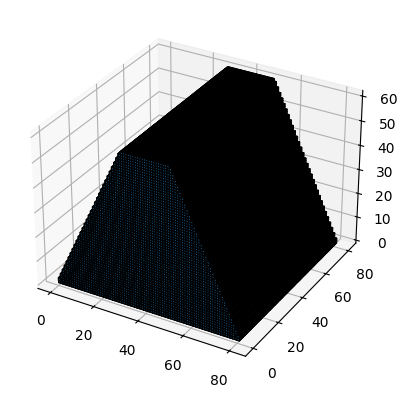

In [35]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.voxels(new_voxels, edgecolor='k')

plt.show()

In [37]:
zv = np.expand_dims(new_voxels, axis=3) 

In [38]:
a = autoencoder.predict(zv)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step


In [ ]:
z = np.load(r'A:\ВУЗМАГА\proect bredixin\voxel_broken\1800izm_voxel.npy')
zv = np.expand_dims(z, axis=3) 

In [40]:
new_a = a[:, :, :, 0, 0]

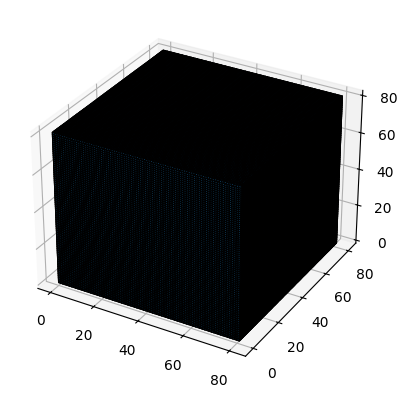

In [41]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.voxels(new_a, edgecolor='k')

plt.show()

In [ ]:
def voxels_to_mesh(voxels):

    vertices = []
    faces = []

    for x in range(voxels.shape[0]):
        for y in range(voxels.shape[1]):
            for z in range(voxels.shape[2]):
                if voxels[x, y, z] > 0:
                    v0 = [x, y, z]
                    v1 = [x + 1, y, z]
                    v2 = [x, y + 1, z]
                    v3 = [x + 1, y + 1, z]
                    v4 = [x, y, z + 1]
                    v5 = [x + 1, y, z + 1]
                    v6 = [x, y + 1, z + 1]
                    v7 = [x + 1, y + 1, z + 1]

                    start_index = len(vertices)
                    vertices.extend([v0, v1, v2, v3, v4, v5, v6, v7])
                    faces.extend([
                        [start_index, start_index + 1, start_index + 2],
                        [start_index + 1, start_index + 3, start_index + 2],
                        [start_index + 4, start_index + 6, start_index + 5],
                        [start_index + 4, start_index + 5, start_index + 7],
                        [start_index + 0, start_index + 2, start_index + 4],
                        [start_index + 2, start_index + 6, start_index + 4],
                        [start_index + 1, start_index + 5, start_index + 3],
                        [start_index + 5, start_index + 7, start_index + 3],
                        [start_index + 0, start_index + 1, start_index + 4],
                        [start_index + 1, start_index + 5, start_index + 4],
                        [start_index + 2, start_index + 3, start_index + 6],
                        [start_index + 3, start_index + 7, start_index + 6]
                    ])

    vertices = np.array(vertices)
    faces = np.array(faces)

    mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
    return mesh

In [ ]:
mesh = voxels_to_mesh(new_a)

mesh.export('model.stl')